本章讨论计算机视觉的特征工程，即如何从图像中设计、提取特征，以及分析具体特征的用途。

特征分为两类：
* 人工设计的特征，即传统特征工程。本章仅讨论这类特征。
* 深度学习中自主学习到的特征。

# 1. Harris 角点检测器

* 图像域中点 x 上的 *对称半正定矩阵* 定义为:

$$ M_I = \Delta I \Delta I^T
    = \begin{pmatrix} I_x \\ I_y \end{pmatrix} 
      \begin{pmatrix} I_x I_y \end{pmatrix} 
    = \begin{pmatrix} 
        I_x^2 & I_x I_y \\
        I_x I_y & I_y^2
      \end{pmatrix} $$
      
其秩为 1，特征值为 $ \lambda_1 = |\Delta I|^2 $ 和 $ \lambda_2 = 0 $.

* 选择权重矩阵 W （通常为高斯滤波器 $ G_\delta $），卷积得到 *Harris 矩阵*：

    $$ \overline M_I = W * M_I $$
    
该卷积的目的是得到 $M_I$ 在周围像素上的局部平均。

* Harris 矩阵的特征值依赖于局部图像特性而变化。如果图像的梯度在该区域变化，那么第二个特征值将不再为 0. 通常使用 $ \frac {det(\overline M_I)} {trace(\overline M_I)^2} $ 作为指示器。

1
2
3


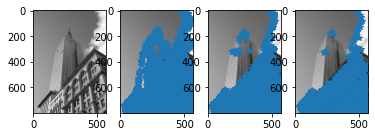

In [29]:
from PIL import Image
from numpy import *
from pylab import *

from scipy.ndimage import filters
from tools import harris
    
    
fig, ax = plt.subplots(nrows=1, ncols=4,)

im = array(Image.open('data/empire.jpg').convert('L'))
ax[0].imshow(Image.fromarray(im))
harrisim = harris.compute_harris_response(im)
for index, threshold in enumerate((0.01, 0.05, 0.1), start=1):
    print(index)
    filtered_coords = harris.get_harris_points(harrisim, 6, threshold=threshold)
    harris.plot_harris_points(im, filtered_coords, subplot=ax[index])


## 在图像间寻找对应点

Harris 角点的描述子通常由图像周围像素块的灰度值，以及用于比较的归一化相关矩阵构成。

* 两个大小相同像素块 $I_1(x)$ 和 $I_2(x)$ 的 *相关矩阵* 定义为：
  $$ c(I_1,I_2) = \sum_x f(I_1(x), I_2(x)) $$
  其中，函数 f 随着相关方法的变化而变化。对于 *互相关矩阵*，$ f(I_1, I_2) = I_1 I_2 $，因此，$ c(I_1, I_2) = I_1 \bullet I_2 $ 。

* *归一化的互相关矩阵* 是互相关矩阵的一种变形，定义为：
  $$ ncc(I_1,I_2) = \frac 1 {n-1}  \sum_x \frac {I_1(x) - \mu_1} {\delta_1} \bullet \frac {I_1(x) - \mu_1} {\delta_2}) $$
  通过减去均值和除以标准差，该方法对图像亮度变化具有稳健性。

MATCH desc1(3083,121) desc2(14182,121)
MATCH desc1(14182,121) desc2(3083,121)


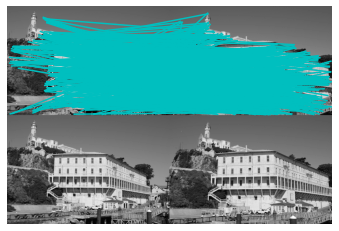

In [59]:
import tools.harris
from importlib import reload
reload(tools.harris)

im1 = array(Image.open('data/alcatraz1.jpg').convert('L'))
im2 = array(Image.open('data/alcatraz2.jpg').convert('L'))
    
wid = 5
harrism = harris.compute_harris_response(im1, 5)
filtered_coords1 = harris.get_harris_points(harrisim, wid+1)
d1 = harris.get_descriptors(im1, filtered_coords1, wid)

harrisim = harris.compute_harris_response(im2, 5)
filtered_coords2 = harris.get_harris_points(harrisim, wid+1)
d2 = harris.get_descriptors(im2, filtered_coords2, wid)

matches = harris.match_twosided(d1, d2)

figure()
gray()
harris.plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches)
show()

# 2. SIFT（Scale-invariant feature transform, 尺度不变特征转换）

SIFT 对于尺度、旋转和亮度都具有不变性，可以用于三维视角和噪声的可靠匹配。

## 兴趣点

SIFT 特征使用 *高斯差分函数（Difference of Gaussians， DoG）* 来定位兴趣点：

$$ D(\mathbf X, \sigma) 
   = [G_{k \sigma}(\mathbf x) - G_\sigma(\mathbf x)]*\mathbf I(\mathbf x)
   = [G_{k \sigma} - G_\sigma]*\mathbf I
   = \mathbf I_{k \sigma} - \mathbf I_\sigma$$
   
其中 $ G_\sigma $ 是二维高斯核，$ \mathbf I_\sigma $ 是使用 $ G_\sigma $ 模糊的灰度图像，k 是决定相差尺度的常数。

DoG 是一种将一个原始灰度图像的模糊图像从另一幅灰度图像进行增强的算法，这个模糊图像是通过将原始灰度图像经过带有不同标准差的高斯核进行卷积得到的。用高斯核进行高斯模糊只能压制高频信息。从一幅图像中减去另一幅可以保持在两幅图像中所保持的频带中含有的空间信息。这样的话，DoG 就相当于一个能够去除除了那些在原始图像中被保留下来的频率之外的所有其他频率信息的带通滤波器。[维基百科：高斯差](https://zh.wikipedia.org/wiki/%E9%AB%98%E6%96%AF%E5%B7%AE)

兴趣点是在图像 **位置和尺度** 变化下 $ D(\mathbf x, \sigma) $ 的最大值和最小值点。 

## 描述子

为了实现 **旋转不变性**，基于每个点周围图像梯度的大小和方向，SIFT 描述子又引入 *主方向* 描述参考方向。

基于位置、尺度、方向信息来计算描述子：

1. 在每个像素点附近选取子区域网络，在每个子区域内计算图像梯度方向直方图；
2. 每个子区域的直方图拼接起来组成描述子向量。

SIFT 描述子的标准设置使用 4*4 的子区域，每个子区域使用 8 个小区间的方向直方图，产生共 128 个小区间的直方图。

SIFT 描述子保存在 *PGM (portable graymap file format，便携式灰度图像格式)* 格式的文本文件中：

    318.861 7.48227 1.12001 1.68523 0 0 0 1 0 0 0 0 0 11 16 0 ...
    ...

每行前 4 个数值依次表示兴趣点的坐标、尺度和方向角度，后面是对应描述符的 128 维向量。

## 检测兴趣点

我们使用开源工具包 [VLFeat](https://www.vlfeat.org/) 计算图像的 SIFT 特征。

使用 vlfeat 时遇到一个 [解析 PGM 文件引起的问题](https://github.com/vlfeat/vlfeat/issues/211) ，不明白其中 `max_value` 的作用，先简单绕过去了。

<PIL.Image.Image image mode=L size=569x800 at 0x110D9FB70>
sift /tmp/tmp.pgm --output /tmp/empire.sift --edge-thresh 10 --peak-thresh 5
processed /tmp/tmp.pgm to /tmp/empire.sift


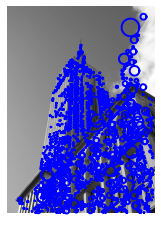

比较 Harris 角点和 SIFT 特征


In [20]:
import tools.sift
from importlib import reload
reload(tools.sift)

from PIL import Image
import numpy as np
from pylab import *

im_fname = 'data/empire.jpg'
sift_fname = '/tmp/empire.sift'
im1 = np.array(Image.open(im_fname).convert('L'))
sift.process_image(im_fname, sift_fname)
l1, d1 = sift.read_features_from_file(sift_fname)

figure()
gray()
sift.plot_features(im1, l1, circle=True)
show()

# TODO 比较 Harris 角点和 SIFT 特征

## 匹配描述子

对于将一幅图像中的特征匹配到另一幅图像的特征，一种稳健的准则是 **使用这两个特征距离和两个最匹配特征距离的比率** 。 该准则保证能够找到足够相似的唯一特征，使错误匹配数降低。

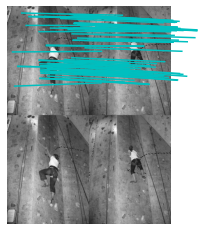

In [56]:
import tools.sift
import tools.harris
from importlib import reload
reload(tools.sift)
reload(tools.harris)

from PIL import Image
from numpy import *
from pylab import *

im1_fname = 'data/climbing_1_small.jpg'
im2_fname = 'data/climbing_2_small.jpg'
im1_siftname = '/tmp/climbing_1_small.sift'
im2_siftname = '/tmp/climbing_2_small.sift'
im1 = array(Image.open(im1_fname).convert('L'))
im2 = array(Image.open(im2_fname).convert('L'))

sift.process_image(im1_fname, im1_siftname)
l1, d1 = sift.read_features_from_file(im1_siftname)

sift.process_image(im2_fname, im2_siftname)
l2, d2 = sift.read_features_from_file(im2_siftname)

matches = sift.match_twosided(d1, d2)

figure()
gray()
harris.plot_matches(im1, im2, l1, l2, matches)
show()

# 3. 匹配地理标记图像

本节使用 SIFT 局部特征描述子来匹配带有地理标记的图像。

In [68]:
# 提取图像特征，结果保存在同名的 .sift 文件中
import tools.sift
from importlib import reload
reload(tools.sift)

import os
from tools import sift

path = 'data/whitehouse'
imlist = map(lambda i: os.path.join(path, i),
             filter(lambda i: os.path.splitext(i)[1] in ('.jpg', '.jpeg'), 
                    os.listdir(path)))
imlist = list(imlist)
featlist = []
for im_name in imlist:
    feat_name = os.path.splitext(im_name)[0] + '.sift'
    sift.process_image(im_name, feat_name)
    featlist.append(feat_name)

In [70]:
# 计算不同图像的匹配特征数
nbr_images = len(imlist)

matchscores = zeros((nbr_images, nbr_images))
for i in range(nbr_images):
    for j in range(i, nbr_images): # 仅计算上三角
        # print('comparing ', imlist[i], imlist[j])
        l1, d1 = sift.read_features_from_file(featlist[i])
        l2, d2 = sift.read_features_from_file(featlist[j])
        matches = sift.match_twosided(d1, d2)
        
        nbr_matches = sum(matches > 0)
        # print('number of matches =', nbr_matches)
        matchscores[i,j] = matchscores[j,i] = nbr_matches

In [78]:
import pandas as pd
pd.DataFrame(matchscores, dtype=int)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2015,0,426,0,2,16,1,0,0,0,0,1,0
1,0,1179,0,1,0,0,6,28,2,0,0,0,7
2,426,0,1792,0,1,17,0,1,0,0,1,0,0
3,0,1,0,1336,1,1,2,3,67,0,0,0,3
4,2,0,1,1,598,1,0,0,3,1,0,0,0
5,16,0,17,1,1,1313,0,0,1,0,1,0,0
6,1,6,0,2,0,0,1213,19,16,0,0,0,3
7,0,28,1,3,0,0,19,1174,0,0,1,0,6
8,0,2,0,67,3,1,16,0,2968,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1127,1,4,0


In [84]:
# 可视化连接图像
import pydot

threshold = 2 # 创建关联需要的最小匹配数目

def add_graph_node(G, i):
    im = Image.open(imlist[i])
    im.thumbnail((128,128))
    filename = '/tmp/{}.png'.format(i)
    im.save(filename)
    G.add_node(pydot.Node(str(i), fontcolor='transparent',
                          shape='rectangle', image=filename))

G = pydot.Dot(graph_type='graph')
for i in range(nbr_images):
    for j in range(i+1, nbr_images):
        if matchscores[i, j] > threshold:
            add_graph_node(G, i)
            add_graph_node(G, j)
            G.add_edge(pydot.Edge(str(i), str(j)))

G.write_png('/tmp/whitehouse.png')

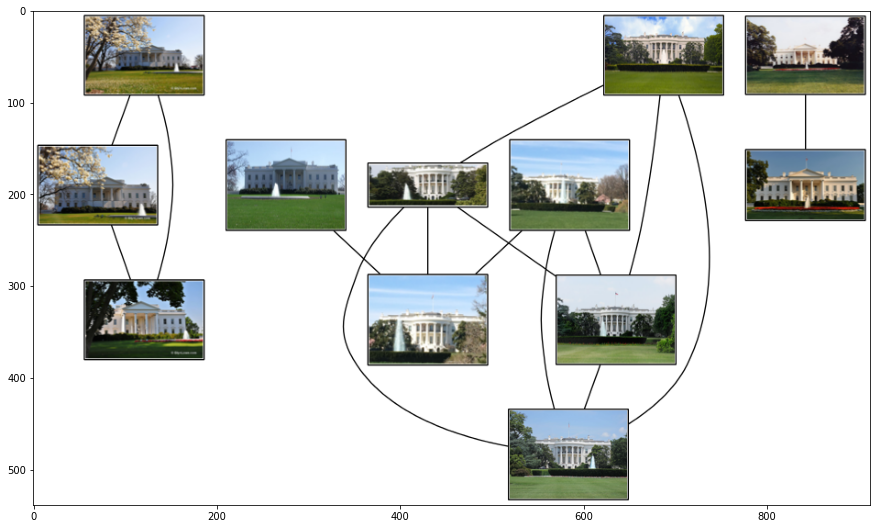

In [98]:
figure(figsize=(15,15))
imshow(Image.open('/tmp/whitehouse.png'))

在该应用中，我们没有针对任何匹配的限制约束。匹配的约束（具有很强的稳健性）可以通过接下来两章中的内容来实现。